In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt


device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'

from upscaling_model import UpscalingModel
from discriminator_model import DiscriminatorModel
from loss_functions import CombinedLoss
from PIL import Image


In [2]:
import os
from hashlib import md5

from PIL import ExifTags
from pillow_heif import register_heif_opener
register_heif_opener()

os.makedirs('test_images', exist_ok=True)

for filename in os.listdir("Test dataset photos"):
    path = os.path.join("Test dataset photos", filename)
    hash = md5(bytearray(path, 'utf-8')).hexdigest()
    img = Image.open(path)

    # https://stackoverflow.com/a/26928142
    for orientation in ExifTags.TAGS.keys():
        if ExifTags.TAGS[orientation]=='Orientation':
            break
    if hasattr(img, '_getexif'):
        exif = img._getexif()
        if exif is not None and orientation in exif:
            if exif[orientation] == 3:
                img=img.rotate(180, expand=True)
            elif exif[orientation] == 6:
                img=img.rotate(270, expand=True)
            elif exif[orientation] == 8:
                img=img.rotate(90, expand=True)

    img = img.convert("RGB")
    img0 = img
    scale = 256/(img.width*img.height)**0.5
    if scale < 1:
        img = img.resize((int(img.width*scale+0.5), int(img.height*scale+0.5)), Image.LANCZOS)
    print(img.width, img.height, filename)
    img.save(os.path.join('test_images', hash+'.png'))
    gt = img0.resize((img.width*3, img.height*3), Image.LANCZOS)
    gt.save(os.path.join('test_images', hash+'-gt.png'))
    bicubic = img.resize((img.width*3, img.height*3), Image.BICUBIC)
    bicubic.save(os.path.join('test_images', hash+'-bicubic.png'))


225 292 IMG_6286 2.jpg
222 295 PXL_20240329_161801625.RAW-01.COVER.jpg
296 222 20240301_131843.jpg
222 296 IMG-20240213-WA0000.jpg
319 206 1212939746330935396-image.png


/home/harry7557558/.local/lib/python3.8/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (101756928 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


296 222 53568265220_59468e4d3a_o.jpg
295 222 PXL_20240329_161646005.RAW-01.COVER.jpg
174 377 IMG_5365.PNG
316 207 d793bfe8-5a9f-48cc-9527-d890c28b99cb.jpg
286 229 IMG-20240205-WA0002.jpg
296 222 20231214_153842.jpg
222 295 PXL_20240329_161349020.RAW-01.COVER.jpg
222 295 PXL_20240329_161429285.RAW-01.COVER.jpg
293 223 image.png
296 222 20230904_163004.jpg
296 222 20240328_112527.jpg
222 296 IMG_2180 2.heic
222 296 20240130_205627.jpg
296 222 20230904_112951.jpg
222 296 IMG_1100 2.HEIC
317 207 Screenshot from 2024-03-27 15-43-05.png
295 222 PXL_20240329_161847168.RAW-01.COVER.jpg
222 296 IMG_1631 2.HEIC


In [27]:
def compute_W_and_B(batch1, batch2):
    # Reshape batches to (batch_size, num_channels, num_pixels)
    batch1 = batch1.view(batch1.size(0), batch1.size(1), -1)
    batch2 = batch2.view(batch2.size(0), batch2.size(1), -1)
    
    # Compute means of the batches
    mean_batch1 = torch.mean(batch1, dim=2, keepdim=True)
    mean_batch2 = torch.mean(batch2, dim=2, keepdim=True)
    
    # Compute centered batches
    centered_batch1 = batch1 - mean_batch1
    centered_batch2 = batch2 - mean_batch2
    
    # Compute covariance matrix
    xTy = torch.matmul(centered_batch1, centered_batch2.transpose(1, 2))
    xTx = torch.matmul(centered_batch1, centered_batch1.transpose(1, 2))
    
    # Compute weight matrix
    W = torch.matmul(torch.linalg.inv(xTx), xTy)
    W = W.transpose(1, 2)

    # Compute bias vector
    B = mean_batch2.squeeze() - torch.matmul(W, mean_batch1).squeeze()

    return W, B

def correct_color_shift(x, y):
    # W, B = compute_W_and_B(y, x)
    # y1 = torch.matmul(W, y.reshape(1, 3, -1)).view_as(y) + B.reshape(y.shape[0], y.shape[1], 1, 1)

    def get_ms_1(x):
        u = torch.mean(x, (2, 3)).reshape((len(x), 3, 1, 1))
        s = torch.std(x, (2, 3)).reshape((len(x), 3, 1, 1))
        return u, s
    ux, sx = get_ms_1(x)
    uy, sy = get_ms_1(y)
    y1 = (y-uy)*(sx/sy)+ux

    return torch.clamp(y1, 0.0, 1.0)


upscale_model = torch.load("final_models/model_8_64_10_12_51_g.pth").to(device)
discrim_model = torch.load("final_models/model_8_64_10_12_51_d.pth").to(device)

criterion = CombinedLoss(0.5, 1.0, 2.0, 0.0, 1.0, device)

def get_loss(image, ref):
    with torch.no_grad():
        image = image.to(device)
        ref = ref.to(device)

        s = (np.array(image.shape)//32)*32
        image = image[:, :, :s[2], :s[3]]
        ref = ref[:, :, :s[2], :s[3]]
        
        generated_outputs = discrim_model(image)
        
        loss = criterion(image, ref, generated_outputs)
        return loss.item()


def plot_imgs(x):
    plt.figure()
    x = torch.clip(x, 0.0, 1.0)
    plt.imshow(np.transpose(vutils.make_grid(x[:4].cpu(),
        nrow=4, padding=2, pad_value=1, normalize=True), (1, 2, 0)),
                interpolation='nearest')
    plt.axis("off")
    plt.show()


model_losses = []
baseline_losses = []

for filename in os.listdir("test_images"):
    if '-' in filename:
        continue
    filename = os.path.join("test_images", filename)
    print(filename)
    img = Image.open(filename)
    x = np.array(img, dtype=np.float32) / 255.0
    x = np.transpose(x, (2, 0, 1))
    x = torch.tensor(x, device=device).unsqueeze(0)
    img = Image.open(filename[:-4]+'-gt.png')
    ref = np.array(img, dtype=np.float32) / 255.0
    ref = np.transpose(ref, (2, 0, 1))
    ref = torch.tensor(ref, device=device).unsqueeze(0)
    img = Image.open(filename[:-4]+'-bicubic.png')
    bicubic = np.array(img, dtype=np.float32) / 255.0
    bicubic = np.transpose(bicubic, (2, 0, 1))
    bicubic = torch.tensor(bicubic, device=device).unsqueeze(0)
    with torch.no_grad():
        y = upscale_model(x)
        # y = correct_color_shift(bicubic, y)
    # plot_imgs(torch.concat((bicubic, y, ref)))
    model_losses.append(get_loss(y, ref))
    baseline_losses.append(get_loss(bicubic, ref))
    print(model_losses[-1], baseline_losses[-1])
    y = y[0].cpu().numpy()
    y = np.transpose(y, (1, 2, 0))
    y = (y*255).astype(np.uint8)
    filename = filename[:filename.rfind('.')] + '-x3.png'
    Image.fromarray(y).save(filename)

test_images/92de6702244303a86415e73c226aad40.png
18.829639434814453 18.251314163208008
test_images/335c9330fb4039d0dad6eac436d41870.png
7.723212242126465 7.26801061630249
test_images/79e4d548c008d6ddd65936694bd39947.png
23.668333053588867 26.818796157836914
test_images/86fa6d32cd5c1c1bbc1edae7c0582736.png
9.365288734436035 10.153703689575195
test_images/705439935649698038a4a9f3965642b8.png
1.6752616167068481 1.6030364036560059
test_images/46bbb3abe03c2165f800a4c23a1d7979.png
9.79660701751709 8.747234344482422
test_images/dbce7fc2513c93ce70dff1331b5e88eb.png
12.72653865814209 11.775479316711426
test_images/d0ac30fa1232f2647ae66e391f63b75f.png
9.66749095916748 9.953254699707031
test_images/6a464ccb3298d7ca722edd0860a68115.png
9.01518440246582 9.058148384094238
test_images/2968097a7600848ac4d355f64252e87c.png
17.616384506225586 17.380403518676758
test_images/2d20003fe50beaf62366be76c2d8d4d7.png
9.95881175994873 11.102357864379883
test_images/5d80e7926fefbe3cd9e1076749d27c0d.png
9.22161960

23
11
10.8267234356507
10.78554365945899


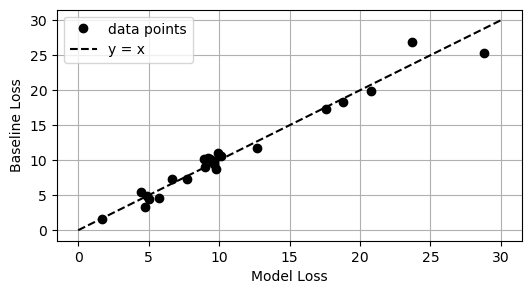

In [37]:
print(len(model_losses))
print(np.sum(np.array(model_losses)<np.array(baseline_losses)))
print(np.mean(model_losses))
print(np.mean(baseline_losses))
plt.figure(figsize=(6, 3))
plt.plot(model_losses, baseline_losses, 'ko', label="data points")
plt.plot([0, 30], [0, 30], 'k--', label="y = x")
plt.xlabel("Model Loss")
plt.ylabel("Baseline Loss")
plt.legend()
plt.grid()
plt.show()